# Portfolio performance

Using codes from the Portfolio Construction file we calculated weights for the next 252 days starting 10/17/2021.

The results are the following:

MSR = SPY: 0.787975 ,TLT:0.212025

GMV = SPY: 0.492367 ,TLT:0.507633

EW = SPY: 0.5 ,TLT:0.5

Benchmark = SPY: 0.6 ,TLT:0.4

Now we will backtest to see how that performed for the next 252 days (ending:10/17/2022) and calculate some measures to test the performance of different portfolio technics between themselves and against the benchmark.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
bt_port = ['SPY','TLT']
pf = yf.download(bt_port, 
                      start='2021-10-17', 
                      end='2022-10-17', 
                      progress=False)
pf = pd.DataFrame(pf["Adj Close"])
bt_rets = pf.pct_change().dropna()
bt_rets

,SPY,TLT
Date,,
2021-10-19,0.007715,-0.013795
2021-10-20,0.003928,-0.006750
2021-10-21,0.002608,-0.001191
2021-10-22,-0.001036,0.011013
2021-10-25,0.005363,-0.001526
...,...,...
2022-10-10,-0.007635,-0.015546
2022-10-11,-0.006333,0.004426
2022-10-12,-0.003298,0.004907


We first downloaded and calculated daily returns for each constituent.

Then, we have to calculate the cumulative daily returns for the given portfolios.

This is performed by the following code:

In [3]:
# Calculate the cumulative daily returns

# MSR Weights: SPY=0.787975, TLT=1-0.787975
msr_cum_daily_returns = (1 + bt_rets).cumprod()*pd.Series({"SPY":0.787975, "TLT":1-0.787975})
msr_rets =(msr_cum_daily_returns["SPY"]+msr_cum_daily_returns["TLT"])
msr_rets.iloc[[0]] = 1

# GMV Weights: SPY=0.492367, TLT=0.507633
gvm_cum_daily_returns = (1 + bt_rets).cumprod()*pd.Series({"SPY":0.492367, "TLT":0.507633})
gvm_rets =(gvm_cum_daily_returns["SPY"]+gvm_cum_daily_returns["TLT"])
gvm_rets.iloc[[0]] = 1

# EW Weights: SPY=0.5, TLT=0.5
ew_cum_daily_returns = (1 + bt_rets).cumprod()*pd.Series({"SPY":0.5, "TLT":0.5})
ew_rets = (ew_cum_daily_returns["SPY"]+ew_cum_daily_returns["TLT"])
ew_rets.iloc[[0]] = 1

# Benchmark Weights: SPY=0.6, TLT=0.4
b_cum_daily_returns = (1 + bt_rets).cumprod()*pd.Series({"SPY":0.6, "TLT":0.4})
b_rets = (b_cum_daily_returns["SPY"]+b_cum_daily_returns["TLT"])
b_rets.iloc[[0]] = 1

The following code shows how to plot the performance for each portfolio. It is hard to spot differences from portfolios GVM and EW since the weights for given portfolios are quite similar.

<AxesSubplot:xlabel='Date'>

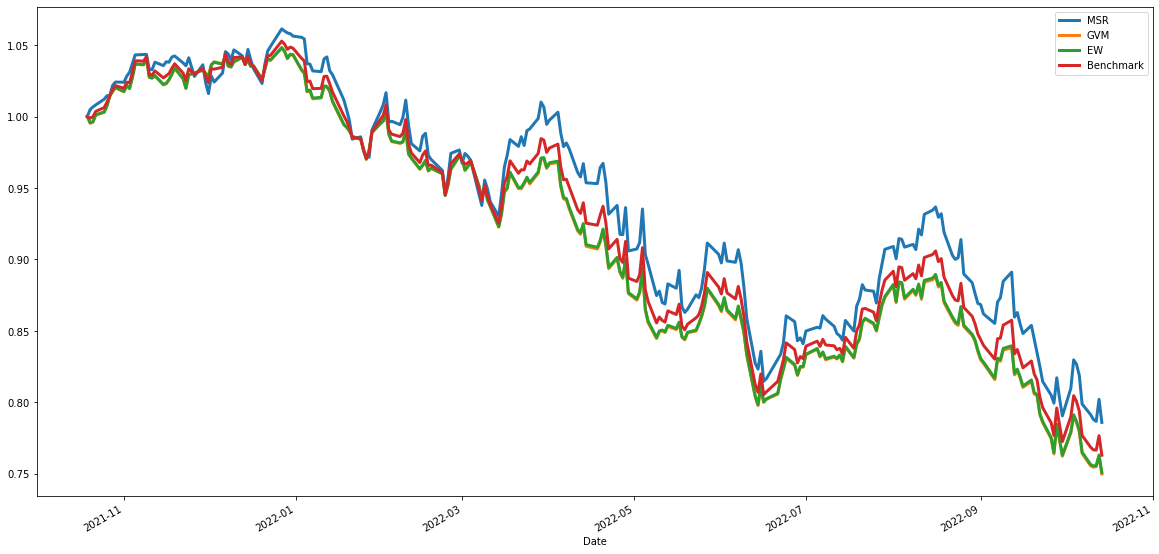

In [4]:
bt_ports_list = pd.concat([msr_rets, gvm_rets, ew_rets, b_rets], axis=1)
bt_ports_list.columns= ["MSR","GVM", "EW", "Benchmark"]
bt_ports_list.plot(figsize=(20,10),ls="-",linewidth=3.0)

# Several Metrics

Next several codes will show how to perform some metrics. 

$Annualized Return, Annualized Volatility, Sharpe Ratio, Drawdown/Max DD, Skewness, Kurtosis, VaR$

In [6]:
# Annualized Return
# An annual or annualized return is a measure of how much an investment has increased on average each year, during a specific time period. 

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [7]:
annualize_rets(bt_ports_list.pct_change().dropna(), bt_ports_list.shape[0])

MSR         -0.214785
GVM         -0.250938
EW          -0.250004
Benchmark   -0.237775
dtype: float64

In [8]:
# Annualized Volatility
# Annualized Volatility is measured as annualised standard deviation of the daily returns of the asset. 
# It is also often referred to as realized, historical, or actual, asset volatility.

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
        """
    return r.std()*(periods_per_year**0.5)

In [9]:
annualize_vol(bt_ports_list.pct_change().dropna(), bt_ports_list.shape[0])

MSR          0.184583
GVM          0.147471
EW           0.147935
Benchmark    0.156828
dtype: float64

In [10]:
# Sharpe Ratio
# The Sharpe Ratio compares the return of an investment with its risk. 
# The Sharpe ratio divides a portfolio's excess returns by a measure of its volatility to assess risk-adjusted performance.

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

In [11]:
FFR_futures_30d = 0.037
sharpe_ratio(bt_ports_list.pct_change().dropna(), riskfree_rate=FFR_futures_30d, periods_per_year=bt_ports_list.shape[0])

MSR         -1.315580
GVM         -1.883075
EW          -1.871086
Benchmark   -1.689785
dtype: float64

In [12]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})


In [13]:
# A drawdown is a peak-to-trough decline during a specific period for an investment, trading account, or fund. 
# A drawdown is usually quoted as the percentage between the peak and the subsequent trough. 

dd_msr = drawdown((bt_ports_list.pct_change().dropna())["MSR"].squeeze())
dd_gmv = drawdown((bt_ports_list.pct_change().dropna())["GVM"].squeeze())
dd_ew = drawdown((bt_ports_list.pct_change().dropna())["EW"].squeeze())
dd_bm = drawdown((bt_ports_list.pct_change().dropna())["Benchmark"].squeeze())

# A maximum drawdown (MDD) is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. 
# Maximum drawdown is an indicator of downside risk over a specified time period.

dd_comparison = (dd_msr["Drawdown"].min(),dd_gmv["Drawdown"].min(),dd_ew["Drawdown"].min(),dd_bm["Drawdown"].min())
dd_comparison = pd.DataFrame(dd_comparison).T
dd_comparison.columns = ["MSR","GVM","EW","Benchmark"]
dd_comparison.index = ['Max Drawdown']

dd_comparison

,MSR,GVM,EW,Benchmark
Max Drawdown,-0.259448,-0.284335,-0.283684,-0.2752


<AxesSubplot:xlabel='Date'>

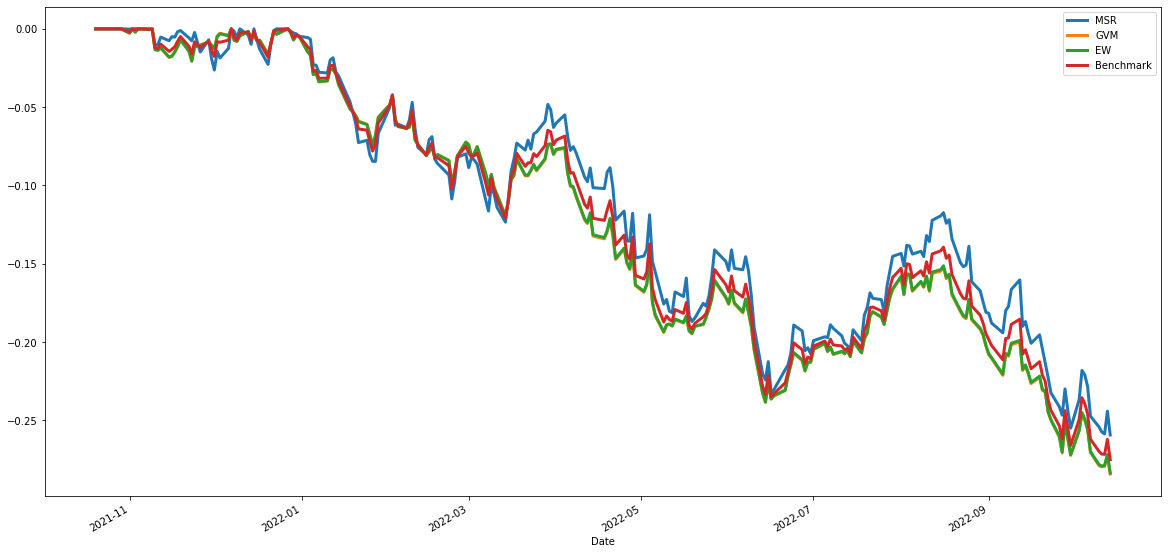

In [15]:
dd_g = (dd_msr["Drawdown"],dd_gmv["Drawdown"],dd_ew["Drawdown"],dd_bm["Drawdown"])
dd_g = pd.DataFrame(dd_g).T
dd_g.columns = ["MSR","GVM","EW","Benchmark"]
dd_g.plot(figsize=(20,10),ls="-",linewidth=3.0)

In [16]:
# Skewness is a measure of the asymmetry of a distribution. A distribution is asymmetrical when its left and right side are not mirror images.  
# A distribution can have right (or positive), left (or negative), or zero skewness. 

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

In [17]:
skew = pd.DataFrame(skewness(bt_ports_list.pct_change().dropna())).T
skew.index = ["Skewness"]
skew

,MSR,GVM,EW,Benchmark
Skewness,-0.276242,-0.307404,-0.308621,-0.31047


In [18]:
# Kurtosis is a measure of the tailedness of a distribution. Tailedness is how often outliers occur. 
# Tails are the tapering ends on either side of a distribution. They represent the probability or frequency of values that are extremely high or low compared to the mean. 
# In other words, tails represent how often outliers occur.

def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

In [19]:
kurt = pd.DataFrame(kurtosis(bt_ports_list.pct_change().dropna())).T
kurt.index = ["Kurtosis"]
kurt

,MSR,GVM,EW,Benchmark
Kurtosis,3.264031,3.400571,3.40125,3.375857


In [20]:
# Value at risk (VaR) is a measure that quantifies the extent of possible financial losses within a portfolio or position over a specific time frame. 
# This metric can be computed in several ways, including the historical, variance-covariance(Parametric Gaussian), and Cornish-Fisher modification. 

from scipy.stats import norm
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gaussian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [21]:
# Conditional Value at Risk (CVaR) is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has.
# CVaR is derived by taking a weighted average of the “extreme” losses in the tail of the distribution of possible returns, beyond the value at risk (VaR) cutoff point.

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [22]:
Parametric_Gaussian_VaR = var_gaussian(bt_ports_list.pct_change().dropna(), level=5, modified=False)
Cornish_Fisher = var_gaussian(bt_ports_list.pct_change().dropna(), level=5, modified=True)
Historic_VaR = var_historic(bt_ports_list.pct_change().dropna(), level=5)
Conditional_VaR = cvar_historic(bt_ports_list.pct_change().dropna(), level=5)

var = pd.DataFrame([Parametric_Gaussian_VaR, Cornish_Fisher,Historic_VaR,Conditional_VaR])
var.index = ["Parametric Gaussian VaR", "Cornish Fisher","Historic VaR", "Conditional VaR"]
var.T

,Parametric Gaussian VaR,Cornish Fisher,Historic VaR,Conditional VaR
MSR,0.020062,0.020898,0.021056,0.027848
GVM,0.016422,0.017144,0.016035,0.020911
EW,0.016465,0.017192,0.016078,0.021004
Benchmark,0.017318,0.018099,0.017336,0.022752


# Summary stats
Finally, we can now put all the above together in one code.

In [24]:
def summary_stats(r, riskfree_rate=0.04, periods_per_year=12):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [25]:
summary_stats(bt_ports_list.pct_change().dropna(), riskfree_rate=0.038, periods_per_year=bt_ports_list.shape[0])

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
MSR,-0.214785,0.184583,-0.276242,3.264031,0.020898,0.027848,-1.319537,-0.259448
GVM,-0.250938,0.147471,-0.307404,3.400571,0.017144,0.020911,-1.887801,-0.284335
EW,-0.250004,0.147935,-0.308621,3.401250,0.017192,0.021004,-1.875803,-0.283684
Benchmark,-0.237775,0.156828,-0.310470,3.375857,0.018099,0.022752,-1.694307,-0.275200


From what we can observe; all four portfolios ended with a loss, which shouldn't surprise us since all markets peaked during the last quarter of 2021 after which the Bear Market started.
In the file portfolio constructed we projected positive returns mostly because we used delta = 2.5, which is a positive number and had an effect on the overall result.
Knowing that; all the metrics are tilted towards negative numbers or have the Bear Market flavor. Nevertheless, it is great to test different portfolio constructions during the downturn.

We can notice that MSR(Max Sharpe Ratio) portfolio beats all other portfolios (including Benchmark) in terms Ann Rets, Sharpe Ratio, and Max DD, while it has the biggest Ann Vol (obviously - it has the most equity exposure), it is more skewed and its kurtosis is the lowest and that opens the door for outliers. On the other hand, GMV(Global Min Variance) portfolio has the smallest realized vol, which is great since that is the main goal of a particular portfolio. Unfortunately, the biggest MDD is presented in the GVM portfolio so even though the portfolio did a "good job" at halting volatilities it did not help on the downside.
